Modelo para distinguir entre tipos de animales

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")
dataset_path = dataset_path + '/raw-img'

print("Path to dataset files:", dataset_path)

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

Using Colab cache for faster access to the 'animals10' dataset.
Path to dataset files: /kaggle/input/animals10/raw-img
System Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version 2.9.0+cu126
Torchvision version 0.24.0+cu126
Numpy version 2.0.2
Pandas version 2.2.2


## Creamos Clase del dataset



In [2]:
class AnimalDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [3]:
dataset = AnimalDataset(data_dir=dataset_path)

In [4]:
print(dataset.classes)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


## Creamos dataloader

In [5]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Creamos modelo

In [6]:
class SimpleAnimalClassifer(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleAnimalClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output



In [7]:
model = SimpleAnimalClassifer(num_classes=10)
print(str(model)[:500])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SimpleAnimalClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=F


## Training
Declare datasets and dataloaders

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = AnimalDataset(dataset_path, transform)

# Split: 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Training Loop

In [9]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0")
model = SimpleAnimalClassifer()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/655 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.49510689525238133, Validation loss: 0.32660424345044164


Training loop:   0%|          | 0/655 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.2715333672185679, Validation loss: 0.2843187567247882


Training loop:   0%|          | 0/655 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.204785199942712, Validation loss: 0.2592073107057168


Training loop:   0%|          | 0/655 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.16064684822865818, Validation loss: 0.30997428103336583


Training loop:   0%|          | 0/655 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1349097839512832, Validation loss: 0.34028369442163486


## Probar Modelo

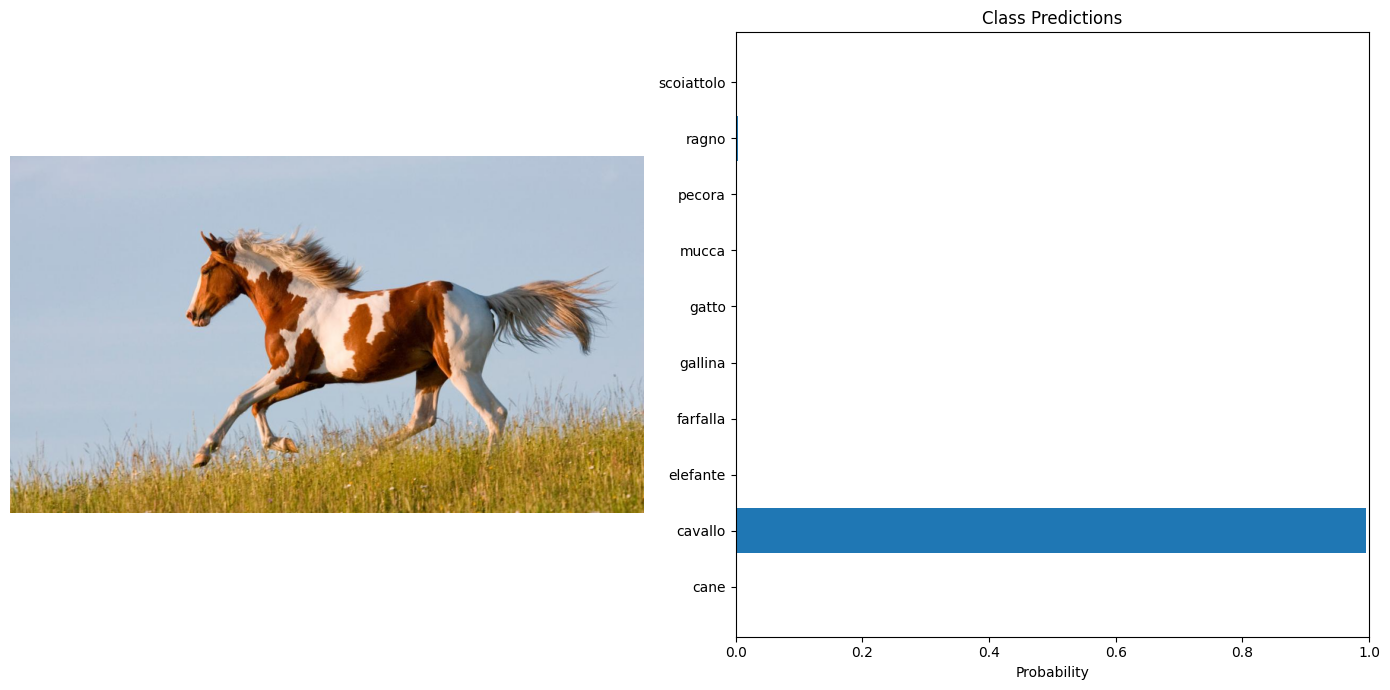

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/caballo.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)